In [37]:
# Standard imports
import matplotlib.pylab as plt
import torch 
import os
import numpy as np
from pathlib import Path

# If you are running this notebook interactively
wdir = Path(os.path.abspath('')).parent.parent
os.chdir(wdir)

# gpytorch imports
from gpytorch.mlls import VariationalELBO
from gpytorch.priors import NormalPrior

%matplotlib inline

# Setting manual seed for reproducibility
torch.manual_seed(73)
np.random.seed(73)

### Set up training data 

We use the canonical multi-phase oilflow dataset used in [Titsias & Lawrence, 2010](http://proceedings.mlr.press/v9/titsias10a/titsias10a.pdf) that consists of 1000, 12 dimensional observations belonging to three known classes corresponding to different phases of oilflow. 

In [38]:
import urllib.request
import tarfile

url = "http://staffwww.dcs.shef.ac.uk/people/N.Lawrence/resources/3PhData.tar.gz"
urllib.request.urlretrieve(url, "3PhData.tar.gz")
with tarfile.open("3PhData.tar.gz", "r") as f:
    f.extract("DataTrn.txt")
    f.extract("DataTrnLbls.txt")

Y = torch.Tensor(np.loadtxt(fname="DataTrn.txt"))
labels = torch.Tensor(np.loadtxt(fname="DataTrnLbls.txt"))
labels = (labels @ np.diag([1, 2, 3])).sum(axis=1)

PermissionError: [Errno 13] Permission denied: '3PhData.tar.gz'

## Defining the GPLVM model

We will be using the BayesianGPLVM model class which is compatible with three different modes of inference. 

(a) Point estimate for the latent variables $X \equiv \{x_{n}\}_{n=1}^{N}$. \
(b) MAP estimate for the latent variables where we have an additional log prior term in the ELBO.

(c) Variational distribution $q(x_{n})$ corresponding to latent variables.

The latent variable ELBO for (c) is given by:

$$\mathcal{L} = \sum_{n, d}\mathbb{E}_{q_{\phi}(\mathbf{x}_{n})}\mathbb{E}_{p(\mathbf{f}_{d}|\mathbf{u}_{d}, \mathbf{x}_{n})q_{\lambda}(\mathbf{u}_{d})}[\log \mathcal{N}(y_{n,d};\mathbf{f}_{d}(\mathbf{x}_{n}), \sigma^{2}_{y})]) - \sum_{n}\textrm{KL}(q_{\phi}(\mathbf{x}_{n})||p(\mathbf{x}_{n})) - \sum_{d}\textrm{KL}(q_{\lambda}(\mathbf{u}_{d})||p(\mathbf{u}_{d}|Z))$$

The latent variable ELBO corresponding to (a) just has the first two terms and corresponding to (b) includes the log prior for latent variables $p(\mathbf{x}_{n})$ in the ELBO.  

This ELBO is optimised w.r.t local variational parameters $\phi$, global variational parameters $\lambda$, kernel hyperparameters $\theta$ and likelihood noise $\sigma^{y}$.

The BayesianGPLVM is built on top of the Sparse GP formulation. Similar to the [SVGP example](../04_Variational_and_Approximate_GPs/SVGP_Regression_CUDA.ipynb), we'll use a `CholeskyVariationalDistribution` to model $q(\mathbf{u})$ and the standard `VariationalStrategy` as defined by Hensman et al. (2015).



In [39]:
from gpytorch.models.gplvm.latent_variable import *
from gpytorch.models.gplvm.bayesian_gplvm import BayesianGPLVM
from matplotlib import pyplot as plt
from tqdm.notebook import trange
from gpytorch.means import ZeroMean
from gpytorch.mlls import VariationalELBO
from gpytorch.priors import NormalPrior
from gpytorch.likelihoods import GaussianLikelihood
from gpytorch.variational import VariationalStrategy
from gpytorch.variational import CholeskyVariationalDistribution
from gpytorch.kernels import ScaleKernel, RBFKernel
from gpytorch.distributions import MultivariateNormal


def _init_pca(Y, latent_dim):
    U, S, V = torch.pca_lowrank(Y, q=latent_dim)
    return torch.nn.Parameter(torch.matmul(Y, V[:, :latent_dim]))


class bGPLVM(BayesianGPLVM):
    def __init__(self, n, data_dim, latent_dim, n_inducing, pca=False):
        self.n = n
        self.batch_shape = torch.Size([data_dim])

        # Locations Z_{d} corresponding to u_{d}, they can be randomly initialized or
        # regularly placed with shape (D x n_inducing x latent_dim).
        self.inducing_inputs = torch.randn(data_dim, n_inducing, latent_dim)

        # Sparse Variational Formulation (inducing variables initialised as randn)
        q_u = CholeskyVariationalDistribution(n_inducing, batch_shape=self.batch_shape)
        q_f = VariationalStrategy(
            self, self.inducing_inputs, q_u, learn_inducing_locations=True
        )

        # Define prior for X
        X_prior_mean = torch.zeros(n, latent_dim)  # shape: N x Q
        prior_x = NormalPrior(X_prior_mean, torch.ones_like(X_prior_mean))

        # Initialise X with PCA or randn
        if pca == True:
            X_init = _init_pca(Y, latent_dim)  # Initialise X to PCA
        else:
            X_init = torch.nn.Parameter(torch.randn(n, latent_dim))

        # LatentVariable (c)
        X = VariationalLatentVariable(n, data_dim, latent_dim, X_init, prior_x)

        # For (a) or (b) change to below:
        # X = PointLatentVariable(n, latent_dim, X_init)
        # X = MAPLatentVariable(n, latent_dim, X_init, prior_x)

        super().__init__(X, q_f)

        # Kernel (acting on latent dimensions)
        self.mean_module = ZeroMean(ard_num_dims=latent_dim)
        self.covar_module = ScaleKernel(RBFKernel(ard_num_dims=latent_dim))

    def forward(self, X):
        mean_x = self.mean_module(X)
        covar_x = self.covar_module(X)
        dist = MultivariateNormal(mean_x, covar_x)
        return dist

    def _get_batch_idx(self, batch_size):
        valid_indices = np.arange(self.n)
        batch_indices = np.random.choice(valid_indices, size=batch_size, replace=False)
        return np.sort(batch_indices)

## Training the model

While we need to specify the dimensionality of the latent variables at the outset, one of the advantages 
of the Bayesian framework is that by using a ARD kernel we can prune dimensions corresponding to small inverse lengthscales.

In [40]:
N = len(Y)
data_dim = Y.shape[1]
latent_dim = data_dim
n_inducing = 25
pca = False

# Model
model = bGPLVM(N, data_dim, latent_dim, n_inducing, pca=pca)

# Likelihood
likelihood = GaussianLikelihood(batch_shape=model.batch_shape)

mll = VariationalELBO(likelihood, model, num_data=len(Y), combine_terms = False)

optimizer = torch.optim.Adam(
    [{"params": model.parameters()}, {"params": likelihood.parameters()}], lr=0.01
)

We use mini-batch training for scalability where only a subset of the local variaitonal params are optimised in each iteration. 

In [41]:
# Training loop - optimises the objective wrt kernel hypers, variational params and inducing inputs
# using the optimizer provided.
plt_ll = []
plt_klu = []
plt_klx = []

loss_list = []
iterator = trange(10000, leave=True)
batch_size = 100
for i in iterator:
    batch_index = model._get_batch_idx(batch_size)
    optimizer.zero_grad()
    sample = (
        model.sample_latent_variable()
    )  # a full sample returns latent x across all N
    sample_batch = sample[batch_index]
    output_batch = model(sample_batch)
    #loss = -mll(output_batch, Y[batch_index].T).sum()
    ll, klu, _, klx = mll(output_batch, Y[batch_index].T)
    plt_ll.append(-ll.sum().item())
    plt_klu.append(-klu.sum().item())
    plt_klx.append(-klx.sum().item())
    loss = -(ll - klx - klu).sum()
    loss_list.append(loss.item())
    iterator.set_description(
        "Loss: " + str(float(np.round(loss.item(), 2))) + ", iter no: " + str(i)
    )
    loss.backward()
    optimizer.step()

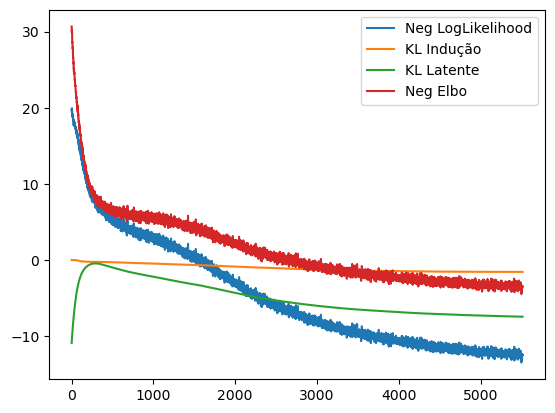

In [47]:
plt.plot(plt_ll, label = "Neg LogLikelihood")
plt.plot(plt_klu, label = "KL Indução" )
plt.plot(plt_klx, label = "KL Latente")
plt.plot(loss_list, label = "Neg Elbo")
plt.legend()
None

## Visualising the 2d latent subspace
Visualising a two dimensional slice of the latent space corresponding to the most dominant latent dimensions.  

In [6]:
inv_lengthscale = 1 / model.covar_module.base_kernel.lengthscale
values, indices = torch.topk(
    model.covar_module.base_kernel.lengthscale, k=2, largest=False
)

l1 = indices.numpy().flatten()[0]
l2 = indices.numpy().flatten()[1]

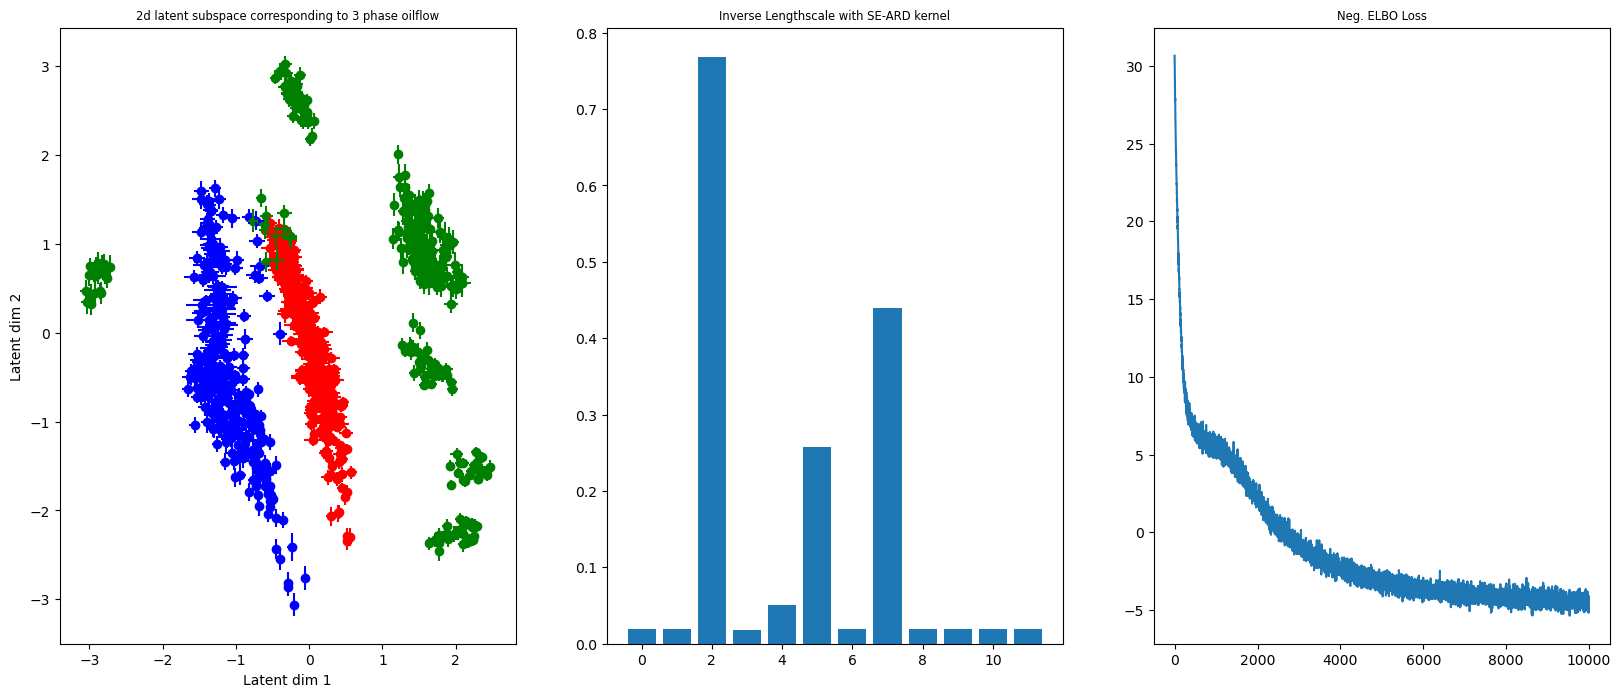

In [7]:
plt.figure(figsize=(20, 8))
colors = ["r", "b", "g"]

plt.subplot(131)
X = model.X.q_mu.detach().numpy()
std = torch.nn.functional.softplus(model.X.q_log_sigma).detach().numpy()
plt.title("2d latent subspace corresponding to 3 phase oilflow", fontsize="small")
plt.xlabel("Latent dim 1")
plt.ylabel("Latent dim 2")

# Select index of the smallest lengthscales by examining model.covar_module.base_kernel.lengthscales
for i, label in enumerate(np.unique(labels)):
    X_i = X[labels == label]
    scale_i = std[labels == label]
    plt.scatter(X_i[:, l1], X_i[:, l2], c=[colors[i]], label=label)
    plt.errorbar(
        X_i[:, l1],
        X_i[:, l2],
        xerr=scale_i[:, l1],
        yerr=scale_i[:, l2],
        label=label,
        c=colors[i],
        fmt="none",
    )

plt.subplot(132)
plt.bar(np.arange(latent_dim), height=inv_lengthscale.detach().numpy().flatten())
plt.title("Inverse Lengthscale with SE-ARD kernel", fontsize="small")

plt.subplot(133)
plt.plot(loss_list, label="batch_size=100")
plt.title("Neg. ELBO Loss", fontsize="small")
None

The vertical and horizontal bars indicate axis aligned Gaussian uncertainty around each latent point. 